In [109]:
import pandas as pd
import numpy as np
import string as str
from os import listdir
from os.path import isfile, join
from  datetime import datetime
from os import listdir
from os.path import isfile, join

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import KFold
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline  
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
import AppVectorizerModule as ATV

In [110]:
#single file
path='/home/ayush/Desktop/BigData_ProjectData/PlayStoreCsv/data/big_data1.csv'
df= pd.read_csv(path,sep=',',header=0)

#whole data
'''dfs=[]
path='../data/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) and f.endswith( 'csv' ) ]
print onlyfiles
for eachFile in onlyfiles:
    path1='../data/'+eachFile
    df1= pd.read_csv(path1,sep=',',header=0)
    print df1.shape[0]
    dfs.append(df1)
df=pd.concat(dfs)
df.shape[0]'''

"dfs=[]\npath='../data/'\nonlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) and f.endswith( 'csv' ) ]\nprint onlyfiles\nfor eachFile in onlyfiles:\n    path1='../data/'+eachFile\n    df1= pd.read_csv(path1,sep=',',header=0)\n    print df1.shape[0]\n    dfs.append(df1)\ndf=pd.concat(dfs)\ndf.shape[0]"

In [111]:
def mapBooleanColumns(x):
    if x==True:
        return 1
    else:
        return 0
    
def mappingScores(x):
    if x>0 and x<=1:
        return 1
    elif x>1 and x<=2:
        return 2
    elif x>2 and x<=3:
        return 3
    elif x>3 and x<=4:
        return 4
    else:
        return 5

def mapDates(d):
    d=d[:10]
    d1= datetime.now()
    d2=datetime.strptime(d, "%Y-%m-%d")
    return (d1.year - d2.year)*12 + d1.month - d2.month    
    
def seperateInstallations(col_name):
    return_data_type_as=None
    ls = col_name.str.split('-').str.get(0).str.strip(' ').str.replace(',','') #series object
    hs = col_name.str.split('-').str.get(1).str.strip(' ').str.replace(',','') #series object
    ls = ls.astype(float).fillna(0.0)
    hs = hs.astype(float).fillna(0.0)
    return ls, hs

def processAppSize(x):
    if x==-1:
        return 0.5
    else:
        return x

In [112]:
# Transforming the data into numerical forms
df.IsTopDeveloper=map(mapBooleanColumns,df.IsTopDeveloper)
df.HaveInAppPurchases=map(mapBooleanColumns,df.HaveInAppPurchases)
df.IsFree=map(mapBooleanColumns,df.IsFree)
df.Score=map(mappingScores,df.Score)
df.PublicationDate=map(mapDates,df.PublicationDate)
df.LastUpdateDate=map(mapDates,df.LastUpdateDate)
df['minInstall'],df['maxInstall']=seperateInstallations(df.Instalations)
df.AppSize=map(processAppSize,df.AppSize)

In [113]:
# Selecting Features
df=df.head(n=500)
X=df[['Price','PublicationDate','AppSize','LastUpdateDate','IsFree','HaveInAppPurchases','minInstall','maxInstall']]
y=pd.DataFrame(df[['Score']])

In [114]:
# Vectorising the features and merging them to selected numerical features     
min_df=1
max_df=0.9
lowercase=True
stem_vectorizer = ATV.StemmedCountVectorizer(encoding='utf-8',
                                         min_df =min_df,
                                         max_df =max_df,
                                         stop_words='english',
                                         analyzer='word',
                                         lowercase = lowercase)
                
##set filterparameter to your vectorizer
filter_by=["OnlyEng", "AllLang"] #two options are available
count_dialect = True 
n_samples = df.shape[0] #as u choose it.
stem_vectorizer.setfilter_option(filter_by[1],count_dialect)    
# Vectorizing the Category Column
nCategory, fmatrix, column_vectorizer = ATV.vectorize_columnTfIdf(df, 'Category', stem_vectorizer,df.shape[0],True)
# Vectorizing the Name Column
stem_vectorizer.setfilter_option(filter_by[0],count_dialect) 
nName, fmatrix1, column_vectorizer1 = ATV.vectorize_columnTfIdf(df, 'Name', stem_vectorizer,df.shape[0],True)
# Vectorizing the Description Column
nDescription, fmatrix2, column_vectorizer2 = ATV.vectorize_columnTfIdf(df, 'Description',stem_vectorizer,df.shape[0],True)
# Vectorizing the Content Rating Column
nContentRating, fmatrix3, column_vectorizer3 = ATV.vectorize_columnTfIdf(df, 'ContentRating',stem_vectorizer,df.shape[0],True)
# Vectorizing the Developer Column
nDeveloper, fmatrix3, column_vectorizer3 = ATV.vectorize_columnTfIdf(df, 'Developer',stem_vectorizer,df.shape[0],True)

finaldf = pd.concat([X,nCategory,nName,nDescription,nContentRating,nDeveloper],axis=1)
#finaldf = pd.concat([X],axis=1)

formed dataframe of size:( 500 , 33 )
formed dataframe of size:( 500 , 530 )
formed dataframe of size:( 500 , 9456 )
formed dataframe of size:( 500 , 8 )
formed dataframe of size:( 500 , 558 )


In [115]:
def getClassifierName(clf):
    if type(clf).__name__ != 'OneVsRestClassifier':
        #print type(clf).__name__
        return type(clf).__name__
    else:
        #print type(clf.estimator).__name__
        return type(clf.estimator).__name__

In [116]:
resultpath='/home/ayush/Desktop/clf_results/'
resultFile=open(resultpath+'Results_Classifier'+'.csv', 'w+')
resultFile.write('Components,Classifier,Accuracy,Precision,Recall')

In [117]:
#resultpath='../clf_results/'
#n_components=[finaldf.shape[1]/int(4),finaldf.shape[1]/int(3),finaldf.shape[1]/int(2),finaldf.shape[1]]
#n_components=[2,6,8]
#n_components=[20,30,40]
n_components=[20,100,200,500,1000,1500,2000,finaldf.shape[1]]
n_kfolds=10

classifiers = [GaussianNB(),BernoulliNB(),RandomForestClassifier(),LogisticRegression(),SGDClassifier(),RidgeClassifier()
              ,DecisionTreeClassifier(),KNeighborsClassifier(),LinearSVC()]
classifierName=['GaussianNB','Bernauli','RandomForest','LogisticRegression','SDGC','RidgeClassifier','DecsionTree','KNeighbour','LinearSVC']
n_component_accuracies = []

for n in n_components:
    xx=finaldf.copy()
    pca = PCA(n_components=n)
    xx= pca.fit_transform(xx)
    yy=y.values
    accuracies=[]
    for clf in classifiers:
            clfname=getClassifierName(clf)
            #print len(xx),clfname
            print 'Start'+clfname
            kf = KFold(len(xx),n_kfolds)
            accuracy=0
            precision=0
            recall=0
            for train_index,test_index in kf:
                X_train, X_test, y_train, y_test = xx[train_index],xx[test_index],yy[train_index],yy[test_index]
                clf.fit(X_train,y_train)                
                y_pred=clf.predict(X_test)
                accScore=accuracy_score(y_test,y_pred)
                precisionScore=precision_score(y_test,y_pred,pos_label=None)
                recallScore=recall_score(y_test,y_pred,pos_label=None)
                #print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred).sum()))
                accuracy += accScore
                precision += precisionScore
                recall += recallScore
            print("Components:%f Classifier:%s Accuracy Score:%f"%(n,clf,accuracy/n_kfolds)) 
            resultFile.write("\n%f,%s,%0.3f,%0.3f,%0.3f"%(n,clfname,accuracy/n_kfolds,precision/n_kfolds,recall/n_kfolds))
            accuracies.append(accuracy/n_kfolds)
            print 'End'+clfname
    n_component_accuracies.append(accuracies)
resultFile.close()

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

StartGaussianNB
Components:20.000000 Classifier:GaussianNB() Accuracy Score:0.340000
EndGaussianNB
StartBernoulliNB
Components:20.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.656000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndBernoulliNB
StartRandomForestClassifier
Components:20.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.628000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndRandomForestClassifier
StartLogisticRegression
Components:20.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.606000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:20.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.104000
EndSGDClassifier
StartRidgeClassifier
Components:20.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.658000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:20.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.528000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:20.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.622000
EndKNeighborsClassifier
StartLinearSVC
Components:20.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.454000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:100.000000 Classifier:GaussianNB() Accuracy Score:0.420000
EndGaussianNB
StartBernoulliNB
Components:100.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.622000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndBernoulliNB
StartRandomForestClassifier
Components:100.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.628000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndRandomForestClassifier
StartLogisticRegression
Components:100.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.620000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:100.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.100000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndSGDClassifier
StartRidgeClassifier
Components:100.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.632000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


EndRidgeClassifier
StartDecisionTreeClassifier
Components:100.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.534000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:100.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.624000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndKNeighborsClassifier
StartLinearSVC
Components:100.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.506000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:200.000000 Classifier:GaussianNB() Accuracy Score:0.418000
EndGaussianNB
StartBernoulliNB
Components:200.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndBernoulliNB
StartRandomForestClassifier
Components:200.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.614000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:200.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.622000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:200.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.134000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndSGDClassifier
StartRidgeClassifier
Components:200.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:200.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.566000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:200.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:200.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.460000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:500.000000 Classifier:GaussianNB() Accuracy Score:0.404000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndGaussianNB
StartBernoulliNB
Components:500.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndBernoulliNB
StartRandomForestClassifier
Components:500.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.642000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:500.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:500.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.236000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


EndSGDClassifier
StartRidgeClassifier
Components:500.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.652000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:500.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.536000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:500.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:500.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.448000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:1000.000000 Classifier:GaussianNB() Accuracy Score:0.404000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndGaussianNB
StartBernoulliNB
Components:1000.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndBernoulliNB
StartRandomForestClassifier
Components:1000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.614000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:1000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:1000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.160000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


EndSGDClassifier
StartRidgeClassifier
Components:1000.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.652000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:1000.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.546000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:1000.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:1000.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.288000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:1500.000000 Classifier:GaussianNB() Accuracy Score:0.404000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndGaussianNB
StartBernoulliNB
Components:1500.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


EndBernoulliNB
StartRandomForestClassifier
Components:1500.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.620000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:1500.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:1500.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.122000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndSGDClassifier
StartRidgeClassifier
Components:1500.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.652000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:1500.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.534000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:1500.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:1500.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.384000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:2000.000000 Classifier:GaussianNB() Accuracy Score:0.404000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndGaussianNB
StartBernoulliNB
Components:2000.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndBernoulliNB
StartRandomForestClassifier
Components:2000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.614000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:2000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:2000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.088000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndSGDClassifier
StartRidgeClassifier
Components:2000.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.652000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:2000.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.552000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:2000.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:2000.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.248000
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


Components:10593.000000 Classifier:GaussianNB() Accuracy Score:0.404000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndGaussianNB
StartBernoulliNB
Components:10593.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.578000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndBernoulliNB
StartRandomForestClassifier
Components:10593.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.604000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndRandomForestClassifier
StartLogisticRegression
Components:10593.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


EndLogisticRegression
StartSGDClassifier
Components:10593.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.216000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndSGDClassifier
StartRidgeClassifier
Components:10593.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.652000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


EndRidgeClassifier
StartDecisionTreeClassifier
Components:10593.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.562000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:10593.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.618000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, reca


EndKNeighborsClassifier
StartLinearSVC
Components:10593.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.368000
EndLinearSVC


/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



In [118]:
# Plotting the graph
plotarrays=np.array(n_component_accuracies)
data = []
for i in range(0,len(classifiers)):
    a=plotarrays[:,i]
    trace = go.Scatter(
        x = n_components,
        y = a,
        name=classifierName[i]
    )
    data.append(trace)


# Plot and embed in ipython notebook!
layout = go.Layout(
    title='Accuracies for various classifiers',
    yaxis=dict(title='Accuracy'),
    xaxis=dict(title='Number of Features after PCA')
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Result_Classifier_500_Alllang')


IndexError: index 9 is out of bounds for axis 1 with size 9

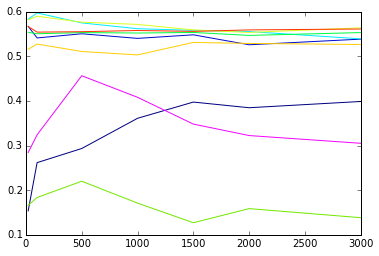

In [75]:
if(True):
    # Plot using matplotlib
    num_plots = len(classifiers)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    # Plot several different functions...
    labels = []
    for i in range(0, num_plots):
        a=plotarrays[:,i]
        #print n_components ,a
        plt.plot(n_components,a)
        labels.append(classifierName[i])

    plt.legend(labels, ncol=4, loc='upper center', 
               bbox_to_anchor=[0.5, -0.15], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True)
    
    plt.xlabel('Number of Features after PCA')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracies vs Features for various classifiers')

    #plt.show()
    plt.savefig(resultpath+'Result_classifier')